In [ ]:
import sys
!{sys.executable} -m pip install pygraphviz

<div style='text-align:center;'>
    <h1>HopRank in BioPortal</h1>
</div>

<h2>Dependencies</h2>

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import os
import graphviz
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.io import mmread
import scipy.sparse as sparse
from scipy.sparse import diags
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from collections import defaultdict
from sklearn.preprocessing import normalize
from networkx.drawing.nx_agraph import to_agraph


<h2>Functions and Methods</h2>

In [2]:
##############################################################################
# AIC
##############################################################################
def AIC(loglikelihood, params, observations):
    if observations/params > 40:
        return (-2 * loglikelihood) + (2 * params) + ((2*params*(params+1))/(observations-params-1))
    return (-2 * loglikelihood) + (2 * params)

def BIC(loglikelihood, params, observations):
    return (-2 * loglikelihood) + (params * np.log(observations))

In [3]:
##############################################################################
# RANDOM WALK
##############################################################################

def random_walk_likelihood(structure, transitions, alpha=0.85):
    params = []
    if alpha is not None and (alpha < 0 or alpha > 1):
        raise ValueError("damping factor must be between 0 and 1 (inclusive).")
        return None, None

    params = [alpha]
    N = structure.shape[0]
    
    if alpha > 0:
        
        if alpha == 1.0:
            alpha = 0.99999
            
        ### random walk
        P = csr_matrix(alpha * normalize(structure, norm='l1', axis=1))
        T = csr_matrix( (np.ones((N,N))*(1-alpha)) / N )
        P = csr_matrix(P + T)
    else:
        ### always random jump (teleportation)
        P = csr_matrix(np.ones((N,N)) / N)
        
    ### log-likelihood
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,params

In [4]:
##############################################################################
# HOP RANK (BIOPORTAL OLD - DEPRECATED)
##############################################################################

#@deprecated
def load_hop_counts(path,ontology,year,nodes):
    
    hops = None #csr_matrix(structure.shape, dtype=np.int16)
    
    for fn in os.listdir(path):        
        if fn.endswith('HOP.mtx') and fn.startswith('{}_{}_'.format(ontology,year)):
            hop = int(fn.split('_')[2].replace('HOP.mtx',''))
            m = mmread(os.path.join(path,fn))            
            m = m * hop
            
            if hops is None:
                hops = m.copy()
            else:
                hops = hops + m
    return hops

#@deprecated
def load_overlaps(fn):
    return pd.read_csv(fn)
    
#@deprecated
def get_alphas(overlaps,onto):
    alphas = overlaps.query("ontology==@onto").sort_values('hop').overlap.values
    return np.append([1-alphas.sum()],alphas)
    
##############################################################################
# HOP RANK
##############################################################################

def hop_counts(structure):
    hops = lil_matrix(structure.shape, dtype=np.int8)
    previous_hops = None
    
    hop = 1
    structure.setdiag(0)
    m = structure.copy()

    hops = np.multiply(m,hop)
    
    while m.sum() > 0:
        
        if previous_hops is None:
            previous_hops = m.copy()
        else:
            previous_hops += m.copy()
        
        m = structure.copy()
        for h in range(hop):
            m = lil_matrix(m.dot(structure))
            m = (m>0).astype(np.int8)
            
        m.setdiag(0)
        m -= previous_hops
        m = (m>0).astype(np.int8)
        m.setdiag(0)
        m.eliminate_zeros()
        
        hop += 1
        hops += np.multiply(m,hop)

    hops.setdiag(0) 
    return hops

def hop_alphas(transitions, hops):    
    maxhops = int(hops.max()) 
    total = transitions.sum() + maxhops + 1
    alphas = np.zeros(maxhops + 1)
    counts = np.zeros(maxhops + 1)
    
    for hop in range(maxhops+1):
        if hop == 0:
            counts[hop] = 1 # for selfloops
        else:
            transitions_in_hop = np.any(hops==hop).astype(np.int8).multiply(transitions)
            counts[hop] = transitions_in_hop.sum() + 1
        alphas[hop] = counts[hop] / total
        
    return alphas, counts

def hop_rank_likelihood(structure, transitions, hops=None, alphas=None):
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):
                
        if hop == 0:
            P = lil_matrix( np.ones((N,N))*(alpha / N ) )
        else:
            m = lil_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))
            P += lil_matrix(alpha * normalize(m, norm='l1', axis=1))
            
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas

def hop_rank_preferential_attachment_likelihood(structure, transitions, hops=None, alphas=None):
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):
                
        if hop == 0:
            P = lil_matrix( np.ones((N,N))*(alpha / N ) )
        else:
            m = lil_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))
            P += lil_matrix(alpha * normalize(m, norm='l1', axis=1))
    
    # joint (hopportation and pref. attachment)
    # P = lil_matrix( np.multiply(P.toarray(), np.repeat(structure.sum(axis=0), N, axis=0) ) )
    
    # mutually exclusive (hopportation or pref. attachment)
    P += lil_matrix( np.repeat(structure.sum(axis=0), N, axis=0) )
    
    # norm
    P = normalize(P, norm='l1', axis=1)
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas

def hop_rank_gravitational_likelihood(structure, transitions, hops=None, alphas=None):
    
    if hops is None:
        hops = hop_counts(structure) # k-hop matrix
    
    if alphas is None:
        alphas, counts = hop_alphas(transitions, hops)
        
    P = None
    N = structure.shape[0]

    for hop, alpha in enumerate(alphas):
                
        if hop == 0:
            P = lil_matrix( np.ones((N,N))*(alpha / N ) )
        else:
            m = lil_matrix(np.isin(hops.toarray(),[hop],assume_unique=False).astype(np.int8))
            P += lil_matrix(alpha * normalize(m, norm='l1', axis=1))
    
    distance = hops.toarray()
    distance[distance==0]= distance.max()+1
    np.fill_diagonal(distance,distance.max()+1)    
    distance = 1/(distance)**2

    # joint (hopportation and pref. attachment)
    # P = lil_matrix( np.multiply( P.toarray(), np.multiply(distance, np.repeat(structure.sum(axis=0), N, axis=0) ) ) )    
    
    # mutually exclusive (hopportation or pref. attachment)
    P += lil_matrix( np.multiply(np.repeat(structure.sum(axis=0), N, axis=0), distance ) )
    
    # norm
    P = normalize(P, norm='l1', axis=1)
    
    l = (transitions.toarray() * np.log(P.toarray())).sum()
    return l,alphas



In [5]:
##############################################################################
# MARKOV CHAIN
##############################################################################

def markov_chain_likelihood(structure, transitions):
    P = normalize(transitions,'l1',axis=1)
    l = (transitions.data * np.log(P.data)).sum()
    
    params = sparse.find(P.tocsr())[2].tolist()
    return l,params

In [6]:
##############################################################################
# VIZ
##############################################################################

def plot_graph(G, title, ax=None, pos=None, small=False):
    M = 20

    if small:
        ns = 50
        fs = 5
    else:
        ns = 700
        fs = 20
        
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
        
    if pos is None:
        # pos = nx.spring_layout(G)  # positions for all nodes
        pos = nx.circular_layout(G)

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=ns, ax=ax)

    # edges
    edges = [(u, v, d) for (u, v, d) in G.edges(data=True)]
    Max = max([e[2]['weight'] if 'weight' in e[2] else 1 for e in edges])

    nx.draw_networkx_edges(G, pos, 
                           edgelist=[(u,v) for (u, v, d) in edges], 
                           width=[ (d['weight']*M)/Max if 'weight' in d else 1 for (u, v, d) in edges], 
                           ax=ax)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=fs, font_family='sans-serif', ax=ax)

    ax.axis('off')
    ax.set_title(title.upper())
    return pos


##############################################################################
# HANDLERS
##############################################################################

def weighted_to_undirected(G):
    tmp = nx.Graph()
    tmp.add_edges_from(G.edges(), weight=0)
    for u, v, d in G.edges(data=True):
        tmp[u][v]['weight'] += d['weight']
    return tmp


<div style='text-align:center;'>
<h1>Toy-Example</h1>
</div>

<h2>Datasets</h2>

In [7]:
##############################################################################
# DATA: AS GRAPHS
##############################################################################

### STRUCTURE
G=nx.DiGraph()
G.add_edge('a','b')
G.add_edge('a','c')
G.add_edge('b','d')
G.add_edge('b','e')
G.add_edge('c','f')
G.add_edge('c','g')

### TRANSITIONS (HOPRANK)
H=nx.DiGraph()
H.add_edge('b','d',weight=1)   # 1hop
H.add_edge('d','e',weight=100) # 2hop
H.add_edge('e','g',weight=15)  # 4hop
H.add_edge('f','d',weight=15)  # 4hop
H.add_edge('f','e',weight=20)  # 4hop
H.add_edge('b','g',weight=5)   # 3hop

# ### TRANSITIONS (1HOP)
# H=nx.DiGraph()
# H.add_edge('a','b',weight=10)
# H.add_edge('a','c',weight=10)
# H.add_edge('b','d',weight=20)
# H.add_edge('b','e',weight=20)
# H.add_edge('c','f',weight=30)
# H.add_edge('c','g',weight=30)

### TO UNDIRECTED
H = weighted_to_undirected(H)

### ADJACENCY MATRICES
S = nx.adjacency_matrix(G.to_undirected(),['a','b','c','d','e','f','g'])
T = nx.adjacency_matrix(H,['a','b','c','d','e','f','g'])

<h2>Experiments and Results</h2>

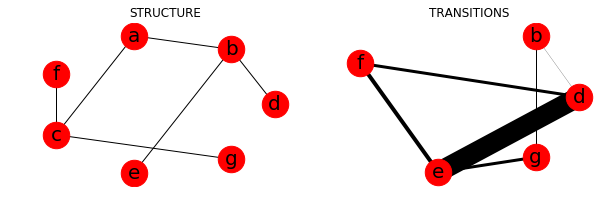

In [8]:
##############################################################################
# Data Vizualization
##############################################################################
fig, axes = plt.subplots(1,2,figsize=(10,3))
pos = plot_graph(G.to_undirected(),title='structure',ax=axes[0],pos=None,small=False)
_ = plot_graph(H,title='transitions',ax=axes[1],pos=pos,small=False)

In [9]:
##############################################################################
# LOG-LIKELIHOODS
##############################################################################

columns = ['method','n-params','log-likelihood','aic','bic']
df = pd.DataFrame(columns=columns)

### RANDOM
alpha = 0.0
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('RANDOM: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'Random', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### STRUCTURE
alpha = 1.0
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('STRUCTURE: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'Structure', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### PAGERANK
alpha = 0.85
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('PAGERANK: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(l,aic,bic))
df = df.append({'method':'PageRank {}'.format(alpha), 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### PAGERANK (DATA)
alpha = round(np.multiply(T.toarray(),S.toarray()).sum() / T.toarray().sum(),2)
l,params = random_walk_likelihood(S,T,alpha)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('PAGERANK {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(alpha,l,aic,bic))
df = df.append({'method':'PageRank {}'.format(alpha), 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### MARKOV CHAIN
l,params = markov_chain_likelihood(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('MARKOV CHAIN {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(len(params),l,aic,bic))
df = df.append({'method':'Markov Chain', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER
l,params = hop_rank_likelihood(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPRANK {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopRank', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER PREF. ATTACHMENT
l,params = hop_rank_preferential_attachment_likelihood(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPRANK PREF. ATTACH. {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopRank Pref. Attach.', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)

### HOPSURFER GRAVITATIONAL
l,params = hop_rank_gravitational_likelihood(S,T)
aic = AIC(l,len(params),S.shape[0])
bic = BIC(l,len(params),S.shape[0])
print('HOPRANK GRAVITATIONAL {}: \n- likelihood: {}\n- AIC: {}\n- BIC: {}\n'.format(params,l,aic,bic))
df = df.append({'method':'HopRank Grav.', 'n-params': len(params), 'log-likelihood':l, 'aic':aic, 'bic':bic}, ignore_index=True)


RANDOM: 
- likelihood: -607.1239665052578
- AIC: 1216.2479330105157
- BIC: 1216.193843159571

STRUCTURE: 
- likelihood: -4173.337666923764
- AIC: 8348.675333847528
- BIC: 8348.621243996584

PAGERANK: 
- likelihood: -1192.6651873470041
- AIC: 2387.3303746940082
- BIC: 2387.2762848430634

PAGERANK 0.01: 
- likelihood: -610.1680564849692
- AIC: 1222.3361129699383
- BIC: 1222.2820231189937

MARKOV CHAIN 12: 
- likelihood: -189.29022236585237
- AIC: 402.58044473170474
- BIC: 401.9313665203685

HOPRANK [0.00315457 0.00946372 0.6340694  0.03470032 0.31861199]: 
- likelihood: -459.9972876019826
- AIC: 929.9945752039652
- BIC: 929.7241259492417

HOPRANK PREF. ATTACH. [0.00315457 0.00946372 0.6340694  0.03470032 0.31861199]: 
- likelihood: -723.4042819105097
- AIC: 1456.8085638210193
- BIC: 1456.538114566296

HOPRANK GRAVITATIONAL [0.00315457 0.00946372 0.6340694  0.03470032 0.31861199]: 
- likelihood: -794.9184766657961
- AIC: 1599.8369533315922
- BIC: 1599.5665040768688



/ssd/lespin/virtualenv/python3.5/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


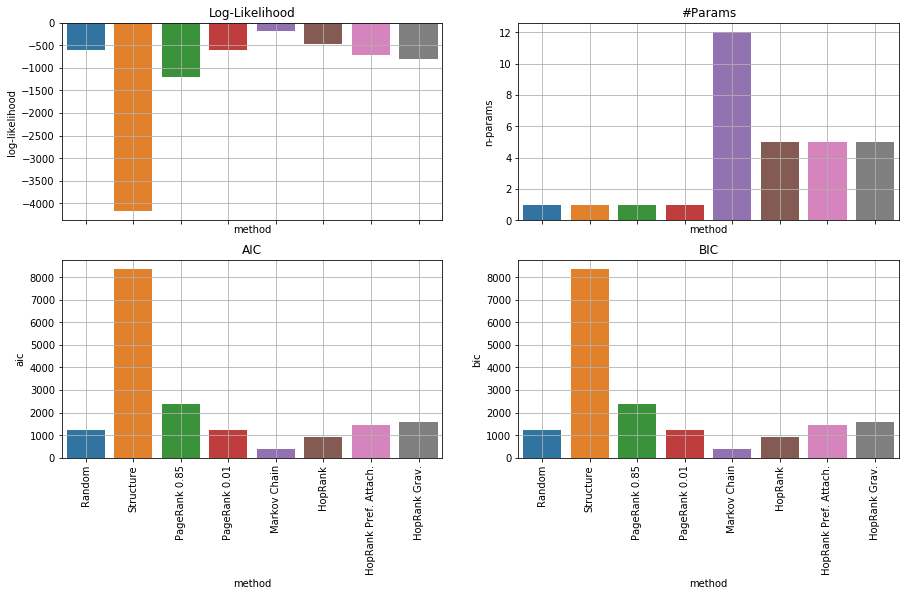

In [10]:
fig,axes = plt.subplots(2,2,figsize=(15,8),sharex=True)
_ = sns.barplot(data=df, x='method',y='log-likelihood',ax=axes[0,0])
_ = sns.barplot(data=df, x='method',y='n-params',ax=axes[0,1])
_ = sns.barplot(data=df, x='method',y='aic',ax=axes[1,0])
_ = sns.barplot(data=df, x='method',y='bic',ax=axes[1,1])

axes[0,0].set_title('Log-Likelihood')
axes[0,1].set_title('#Params')
axes[1,0].set_title('AIC')
axes[1,1].set_title('BIC')

for ax in axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.grid()